# Leveraging LangChain to Build a Multi-Document Querying Application

Original

https://colab.research.google.com/drive/1Q-lm-apSJRYwoPvUZGiwYMezeky0yQXD?usp=sharing

We'll be building off the following diagram off the following diagram!

While it may look a bit complicated, we'll be tackling each piece individually!

Let's dig in!

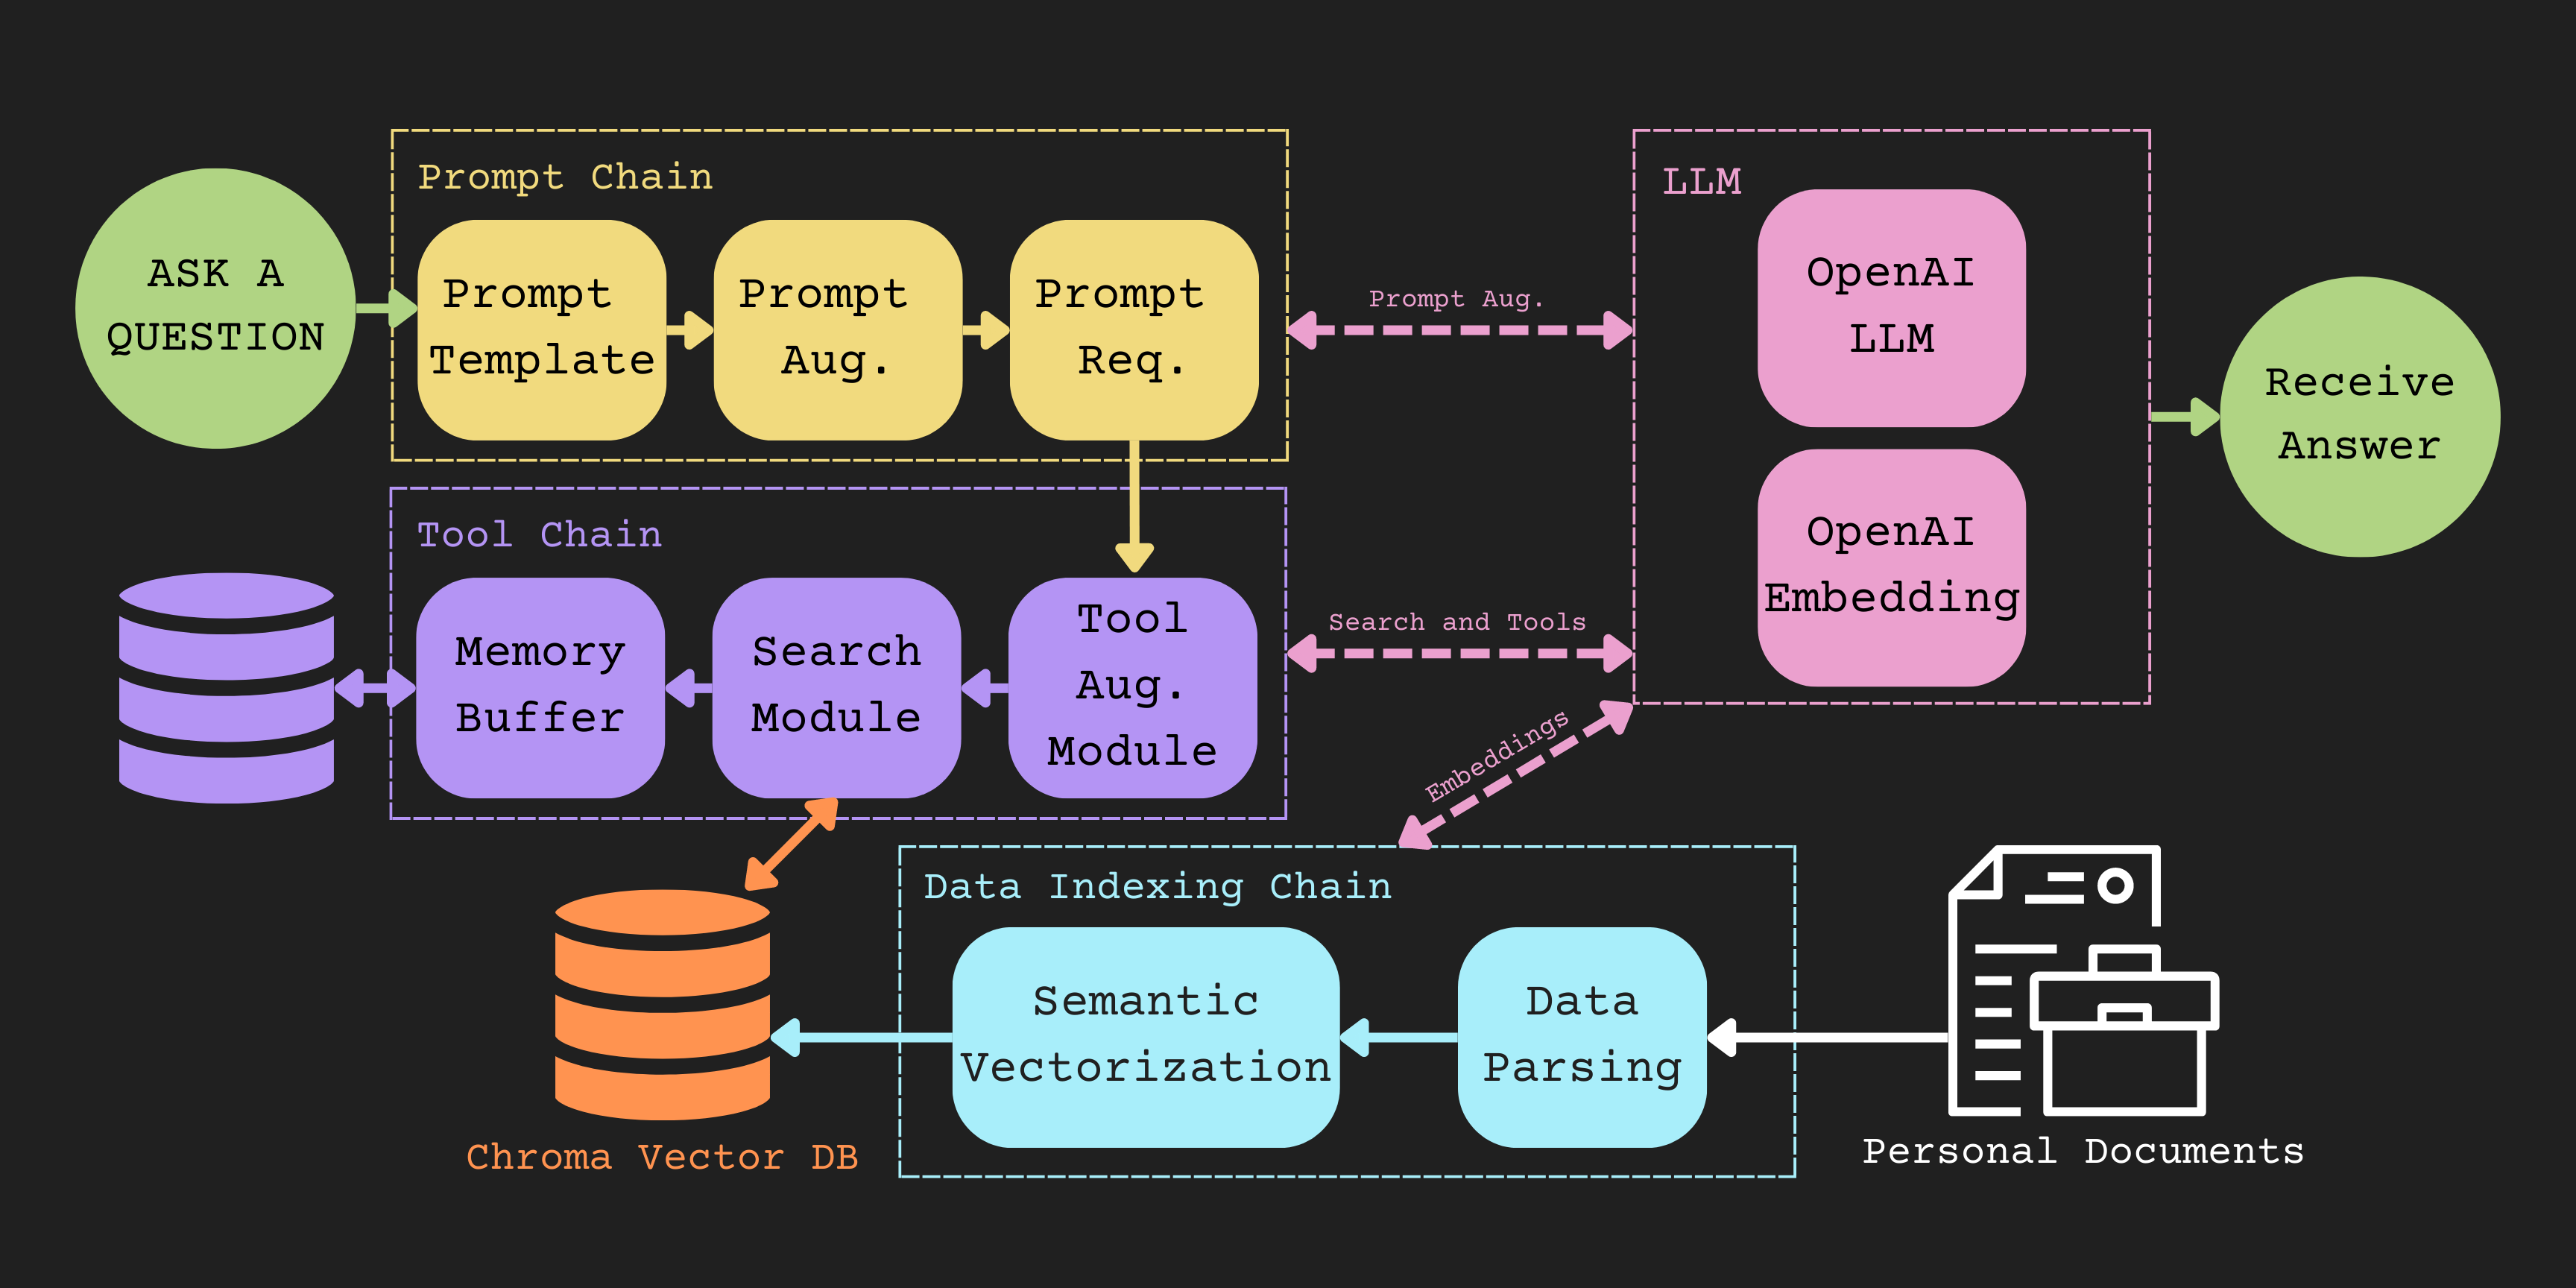

### Loading Source Data

In order to get started, we'll first need a number of documents that we want to collect and manage.

In [ ]:
#!pip install -qU langchain-openai
#!pip install pypdf
#!pip install chromadb tiktoken -q
#!pip install langchain-community
#!pip install -qU langchain-text-splitters
#!pip install -qU langchain

In [1]:
from glob import glob
import os

# Match all files recursively
files = glob("./pnh_data/seleccion/**/*", recursive=True)
# Filter out directories, keeping only files
files_only = [f for f in files if not os.path.isdir(f)]

In [2]:
print(files_only)

['./pnh_data/seleccion/4.pdf', './pnh_data/seleccion/3.pdf', './pnh_data/seleccion/1.pdf', './pnh_data/seleccion/2.pdf']


In [5]:
data_dir = './pnh_data/seleccion/'

Have a look at [this link](https://python.langchain.com/en/latest/modules/indexes/document_loaders.html) to see the full number of `DocumentLoader`s available.


In [4]:
from langchain_community.document_loaders import PyPDFDirectoryLoader

In [6]:
# load PDF files from a directory
loader = PyPDFDirectoryLoader(data_dir)
data = loader.load()
# print the loaded data, which is a list of tuples (file name, text extracted from the PDF)


In [7]:
print(data)

[Document(page_content='', metadata={'source': 'pnh_data/seleccion/4.pdf', 'page': 0}), Document(page_content='La tierra rural en Río Negro:\nhistoria y an tropología\nOcurrencia de herbívoros\ninvasores e in terac ciones\ncon carnívoros nativos \n¿Cómo aprenden y qué recuerdan\nlas chaque tas amarillas?\nArqueología del lago Nahuel Huapi:\nmodelos de uso de los ambien tes y\nde los recursos f aunís ticos\nEvaluación de c alidad de\nagua median te el es tudio\nde macroin vertebrados.Editor responsable:\nDepart amen to de Conser vación y E ducación Ambien tal\nIntendencia del P arque Nacional Nahuel Huapi\nSan Martín 24 - (8400) S. C. de Bariloche\nTel.:(0294) 442-3111 - macr oscopia2015@gmail.c om\nDirector:\nMaría Susana Seijas\nEditor en Je fe:\nFlavia Quin tana\nEquipo E ditorial:\nSebas tián Ballari\nMaría Noelia Barrios Gar cía Moar\nGloria F ernánde z Cánepa\nJulie ta Massa ferro\nHoracio P aradela\nCarla P ozzi\nColabor ador es:\nFernanda Mon tes de Oc a\nLuciana Mot ta\nDiseñad

In [8]:
#from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_text_splitters import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size = 1000,
    chunk_overlap  = 20,
    length_function = len,
)

documents = text_splitter.split_documents(data)

Now that we have our documents split - we need to convert them into embeddings!

First up, we'll set-up our OpenAI API key!

In [26]:
#import os

import os
from dotenv import load_dotenv

load_dotenv("/home/dario/Dropbox/ai/key.env",override=True)
os.environ["OPENAI_API_KEY"] = os.environ['PNH_RAG_OPENAI_KEY']

In [11]:
from langchain_openai import OpenAIEmbeddings

In [12]:
embeddings = OpenAIEmbeddings()

Now we can embed our chunked documents into a ChromaVectorDB!

We are going to be going through the example of persisting this particular DB - but we won't be leveraging the persisted version.

For the example, we just want to showcase how you would persist this particular VectorDB.

You'll notice that there is some GPU usage during this process - since we're leveraging Sentence Transformers to do our embeddings.

It will also take some time, for that same reason.

In [16]:
from langchain_community.vectorstores import Chroma
persist_directory = "./vector_db"



In [17]:
vectordb = Chroma.from_documents(documents=documents, embedding=embeddings, persist_directory=persist_directory)

Now we can persist our Chroma vector store - and then show an example of how you would load that persisted vector store.

In [18]:
vectordb.persist()
vectordb = None

As you can see when you run the following cell - loaded the persisted vectore store is *much* quicker than reinstantiating it - and that is the benefit of `persist_directory`!

In [15]:
vectordb = Chroma(persist_directory=persist_directory, embedding_function=embeddings)

Now, if you were paying close attention you'll realize that we actually only added our `.htm` resources.

So how do we add additional resources to our already created vector database, we'll - let's find out!

First thing we'll need to do is collect our `.txt` documents into a loader and split them into similarly sized documents.

In [ ]:
#from langchain.document_loaders import TextLoader, DirectoryLoader

#txt_dir_loader = DirectoryLoader('./data/txt', loader_cls=TextLoader)

#txt_data = txt_dir_loader.load()

We can resuse our `RecursiveCharacterSplitter` from above without issue.

In [ ]:
#txt_documents = text_splitter.split_documents(txt_data)

Now, when we repeat the process to add documents to our Chroma vector databse, we should see the new documents added!

In [ ]:
#vectordb = Chroma.from_documents(documents=txt_documents, embedding=embeddings, persist_directory=persist_directory)

In [18]:
vectordb.similarity_search("fauna del parque")

[Document(page_content='Los Guardaparques tienen a cargo el control y la \nvigilancia del Parque Nacional, los monitoreos de \nfauna, control de especies exóticas y tareas de \neducación ambiental e interpretación.', metadata={'page': 14, 'source': '/home/dario/Dropbox/ai/pnh-qa/pnh_data/.pdf/seleccion/1. Guía del PNNH.pdf'}),
 Document(page_content='Con respecto a la fauna, entre las especies exóticas que       \namarilla, los abejorros, la codorniz de California, el faisá  \n-solo en isla Victoria-, el ciervo colorado, el jabalí, el visó\namericano, la liebre europea y en los ambientes\nacuáticos las truchas arcoiris, marrón y de arroyo y el\nsalmón encerrado.\nProteger y conservar lo nativo de un país es prioridad, es \nello que en la actualidad desde el Parque Nacional Nahu\nHuapi se están llevando adelante acciones tendientes al\ncontrol de las especies exóticas y sus poblaciones.\nEn este rincón del planeta conviven plantas y animales q\nle dan forma a este paisaje desde hace mil

### Tool Chain

We'll be looking to leverage the entire LangChain suite combined with OpenAI to build a full application - with memory and all!

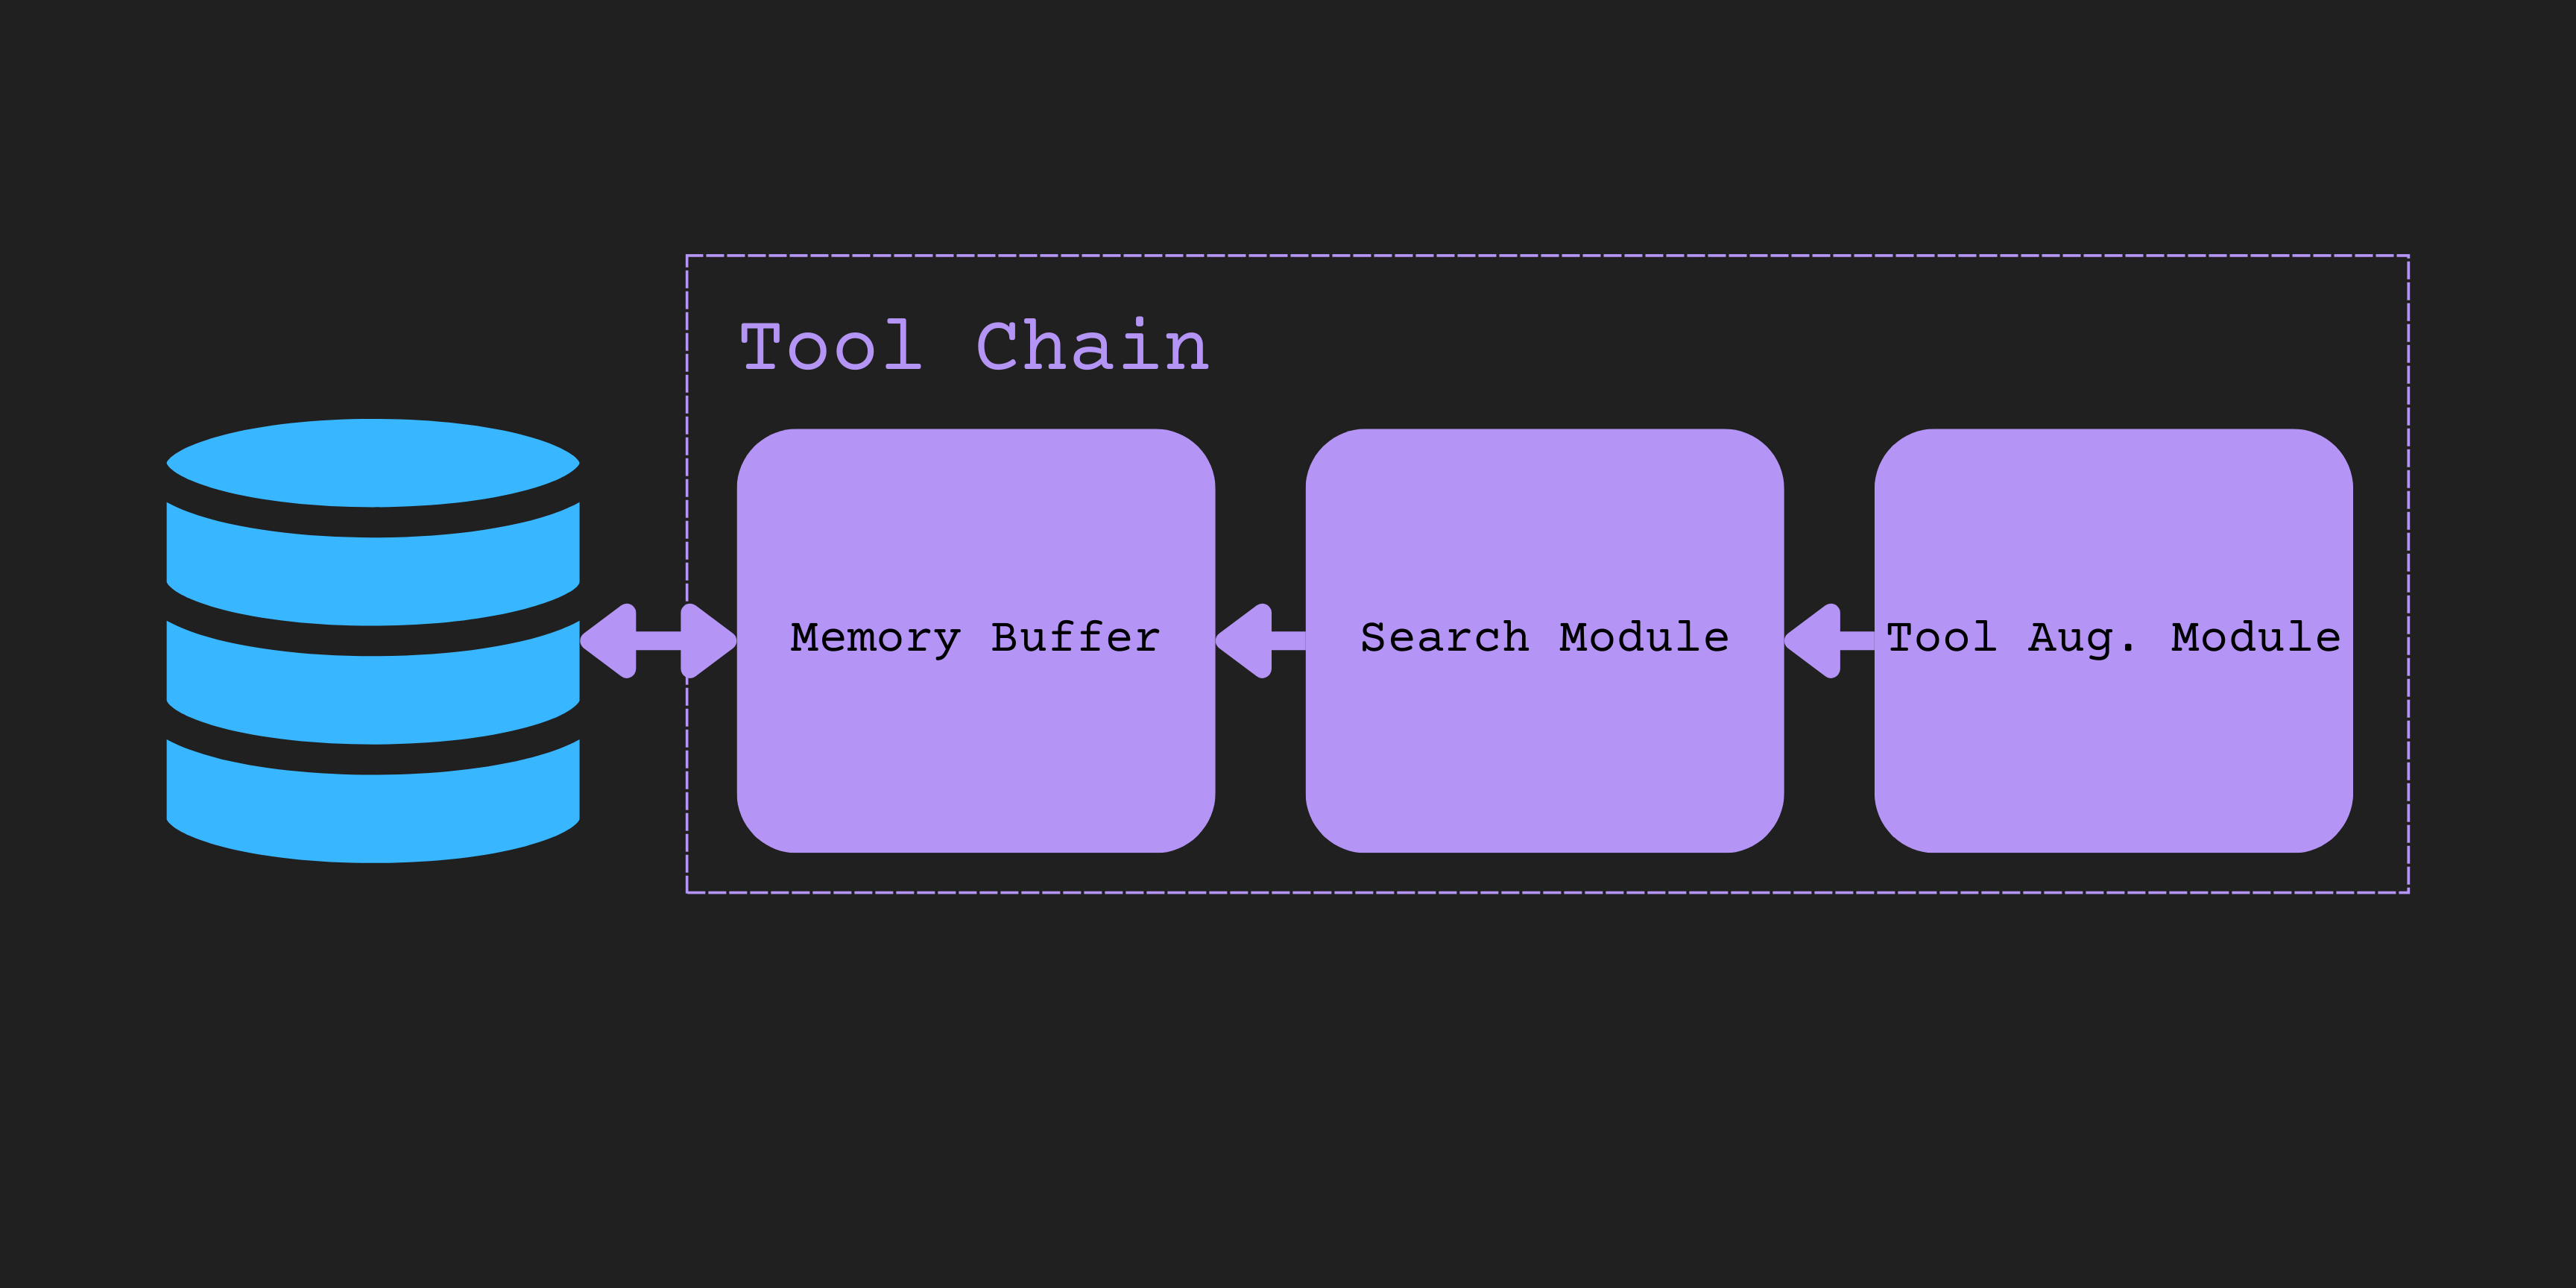


First up, let's load our model!

In [19]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(temperature=0, model="gpt-3.5-turbo")

Now let's set up our document vector store as a Retriever tool so we can leverage it in our chain!

In [20]:
doc_retriever = vectordb.as_retriever()

With that set-up, we're good to set-up our RetrievalQA chain and leverage all the documents we have in our Vector DB!

In [21]:
from langchain.chains import RetrievalQA

pnh_qa = RetrievalQA.from_chain_type(llm=llm, chain_type="stuff", retriever=doc_retriever)

Let's test it out by itself!

In [22]:
pnh_qa.invoke("Que caracteristicas tiene el lago Mascardi?")

{'query': 'Que caracteristicas tiene el lago Mascardi?',
 'result': 'El lago Mascardi tiene una profundidad máxima de 218 metros y forma una especie de herradura con dos brazos. También es conocido como Relmulafken por el pueblo mapuche, lo que significa lago del arco iris. Además, el río Manso nace en el glaciar Manso del cerro Tronador y desemboca en el lago Mascardi.'}

Now, let's set-up a search tool leveraging SERP API!

You can find the process to set this up [here](https://serpapi.com/)

In [ ]:
#!pip install google-search-results -q

  Preparing metadata (setup.py) ... done


In [27]:
serpapi_api_key = os.environ["SERPAPI_API_KEY"]

In [29]:
from langchain.utilities import SerpAPIWrapper

search = SerpAPIWrapper(serpapi_api_key=serpapi_api_key)

Now we can combine those

In [30]:
from langchain.agents import initialize_agent, Tool
from langchain.agents import AgentType
from langchain.tools import BaseTool
# from langchain.llms import OpenAI
from langchain import SerpAPIWrapper

tools = [
    Tool(
        name = "Parque Nahuel Huapi QA System",
        func=pnh_qa.invoke,
        description="Util para responder preguntas sobre el Parque Nacional Nahuel Huapi, en la Patagonia Argentina. La entrada debería ser una pregunta completamente formulada.",
        output_keys=["Sistema de preguntas y respuestas del Parque Nahuel Huapi"]
    ),
    Tool(
        name = "Alternativa del buscador Google para PNNH",
        func=search.run,
        description="Útil para cuando necesitas responder preguntas sobre el Parque Nahuel Huapi pero solo cuando el Sistema del Parque Nahuel Huapi no pudo responder a la consulta. La entrada debería ser una pregunta completamente formulada.",

    ),
]

In [ ]:
%pip install langchainhub -q

In [31]:
from langchain import hub
from langchain.agents import AgentExecutor, create_react_agent
agent_prompt = hub.pull("hwchase17/react-chat")
agent = create_react_agent(llm, tools, agent_prompt)
agent_executor = AgentExecutor(agent=agent,tools=tools)
#agent_executor = AgentExecutor(agent=agent, tools=tools, memory=memory)

In [ ]:
print(agent_prompt)

input_variables=['agent_scratchpad', 'chat_history', 'input', 'tool_names', 'tools'] metadata={'lc_hub_owner': 'hwchase17', 'lc_hub_repo': 'react-chat', 'lc_hub_commit_hash': '3ecd5f710db438a9cf3773c57d6ac8951eefd2cd9a9b2a0026a65a0893b86a6e'} template='Assistant is a large language model trained by OpenAI.\n\nAssistant is designed to be able to assist with a wide range of tasks, from answering simple questions to providing in-depth explanations and discussions on a wide range of topics. As a language model, Assistant is able to generate human-like text based on the input it receives, allowing it to engage in natural-sounding conversations and provide responses that are coherent and relevant to the topic at hand.\n\nAssistant is constantly learning and improving, and its capabilities are constantly evolving. It is able to process and understand large amounts of text, and can use this knowledge to provide accurate and informative responses to a wide range of questions. Additionally, Assi

In [34]:
agent_executor.invoke({
 "input": "Que es el Challhuaco?",
        # Notice that chat_history is a string
        # since this prompt is aimed at LLMs, not chat models
        "chat_history": "Hablamos del Parque Nacional Nahuel Huapi. Las respuestas deben ser en español"
        })

{'input': 'Que es el Challhuaco?',
 'chat_history': 'Hablamos del Parque Nacional Nahuel Huapi. Las respuestas deben ser en español',
 'output': 'El Challhuaco es un cerro ubicado a 18 kilómetros de la ciudad de San Carlos de Bariloche, en Argentina. Es un lugar encantador en el que la naturaleza se manifiesta de diversas formas, con paisajes únicos y una variedad de especies animales y vegetales.'}

Now, let's add some memory to our application!

In [35]:
from langchain.memory import ConversationBufferMemory, ReadOnlySharedMemory

memory = ConversationBufferMemory(memory_key="chat_history")
readonlymemory = ReadOnlySharedMemory(memory=memory)

In order to let our Tools leverage the memory - we'll want to add the ability to read the memory to their chains!

In [36]:
pnh_qa = RetrievalQA.from_chain_type(llm=llm, chain_type="stuff", retriever=doc_retriever, memory=readonlymemory)

Now we can re-create our Tools list - this time using the memory capable version of the 'pnh_qa' chain!

In [37]:
tools = [
    Tool(
        name = "Parque Nahuel Huapi QA System",
        func=pnh_qa.invoke,
        description="Util para responder preguntas sobre el Parque Nacional Nahuel Huapi, en la Patagonia Argentina. La entrada debería ser una pregunta completamente formulada.",
        output_keys=["Sistema de preguntas y respuestas del Parque Nahuel Huapi"]
    ),
    Tool(
        name = "Alternativa del buscador Google para PNNH",
        func=search.run,
        description="Útil para cuando necesitas responder preguntas sobre el Parque Nahuel Huapi pero solo cuando el Sistema del Parque Nahuel Huapi no pudo responder a la consulta. La entrada debería ser una pregunta completamente formulada.",

    ),
]

In [38]:
tools2 = [
    Tool(
        name = "Parque Nahuel Huapi QA System",
        func=pnh_qa.invoke,
        description="Util para responder preguntas sobre el Parque Nacional Nahuel Huapi, en la Patagonia Argentina. La entrada debería ser una pregunta completamente formulada.",
        output_keys=["Sistema de preguntas y respuestas del Parque Nahuel Huapi"]
    ),
]

Let's now add some of the prompt pieces so our agent can respond exactly as we expect!

Now let's add this prompt template to our OpenAI LLM!

Now we can set up our final agent!

In [39]:
user_prompt = '''
El asistente es un experto en el Parque Nacional Nahuel Huapi, en Argentina. Siempre quiere ayudar y proporcionar información a aquellos interesados en el Parque Nahuel Huapi. Da información en español basada en los documentos que se le proporcionan. Cuando no sabe una respuesta responde "No sé".

TOOLS:
------

Assistant has access to the following tools:

{tools}

To use a tool, please use the following format:

```
Thought: Do I need to use a tool? Yes
Action: the action to take, should be one of [{tool_names}]
Action Input: the input to the action
Observation: the result of the action
```

When you have a response to say to the Human, or if you do not need to use a tool, you MUST use the format:

```
Thought: Do I need to use a tool? No
Final Answer: [your response here]
```

Begin!

Previous conversation history:
{chat_history}

New input: {input}
{agent_scratchpad}
'''

In [40]:
from langchain_core.prompts import PromptTemplate
# Define the prompt template
prompt_template = PromptTemplate(
    input_variables=["input", "chat_history", "tools", "tool_names", "agent_scratchpad"],
    template=user_prompt,
)

In [41]:
from langchain import hub
from langchain_openai import OpenAI
from langchain.agents import AgentExecutor, create_react_agent

prompt = prompt_template
#prompt = hub.pull("hwchase17/react")
model = OpenAI()

agent = create_react_agent(model, tools, prompt)

In [42]:
agent_chain = AgentExecutor.from_agent_and_tools(agent=agent, tools=tools, verbose=True, memory=memory,handle_parsing_errors=True,)

Let's test this out!

In [43]:
agent_chain.invoke({"input":"Que actividades se realizan en invierno en el parque nahuel huapi?"})



> Entering new AgentExecutor chain...
Thought: Do I need to use a tool? Yes
Action: Parque Nahuel Huapi QA System
Action Input: Que actividades se realizan en invierno en el parque nahuel huapi?{'query': 'Que actividades se realizan en invierno en el parque nahuel huapi?', 'chat_history': '', 'result': 'En el Parque Nacional Nahuel Huapi, durante el invierno, se pueden realizar actividades como esquí nórdico y de fondo, además de otras actividades como trekking, cabalgatas, pesca deportiva, entre otras.'}Do I need to use a tool? No
Final Answer: En el Parque Nacional Nahuel Huapi, durante el invierno, se pueden realizar actividades como esquí nórdico y de fondo, además de otras actividades como trekking, cabalgatas, pesca deportiva, entre otras.

> Finished chain.


{'input': 'Que actividades se realizan en invierno en el parque nahuel huapi?',
 'chat_history': '',
 'output': 'En el Parque Nacional Nahuel Huapi, durante el invierno, se pueden realizar actividades como esquí nórdico y de fondo, además de otras actividades como trekking, cabalgatas, pesca deportiva, entre otras.'}

In [44]:
agent_chain.invoke({"input":"Como se puede visitar el valle del Chalhuaco?"})



> Entering new AgentExecutor chain...
Thought: Do I need to use a tool? Yes
Action: Parque Nahuel Huapi QA System
Action Input: Como se puede visitar el valle del Chalhuaco?{'query': 'Como se puede visitar el valle del Chalhuaco?', 'chat_history': 'Human: Que actividades se realizan en invierno en el parque nahuel huapi?\nAI: En el Parque Nacional Nahuel Huapi, durante el invierno, se pueden realizar actividades como esquí nórdico y de fondo, además de otras actividades como trekking, cabalgatas, pesca deportiva, entre otras.', 'result': 'Se puede visitar el valle del Challhuaco de manera independiente en vehículo o contratando el traslado con guía en alguna de las agencias de turismo de Bariloche. En el trayecto se puede observar la cadena montañosa que rodea la ciudad, con vistas a los cerros Catedral, Ventana, Ñireco y Carbón. Además, entre los meses de mayo y octubre es obligatorio contratar un guía de montaña habilitado para visitar el valle del Challhuaco.'}Do I need to use a t

{'input': 'Como se puede visitar el valle del Chalhuaco?',
 'chat_history': 'Human: Que actividades se realizan en invierno en el parque nahuel huapi?\nAI: En el Parque Nacional Nahuel Huapi, durante el invierno, se pueden realizar actividades como esquí nórdico y de fondo, además de otras actividades como trekking, cabalgatas, pesca deportiva, entre otras.',
 'output': 'Se puede visitar el valle del Challhuaco de manera independiente en vehículo o contratando el traslado con guía en alguna de las agencias de turismo de Bariloche. En el trayecto se puede observar la cadena montañosa que rodea la ciudad, con vistas a los cerros Catedral, Ventana, Ñireco y Carbón. Además, entre los meses de mayo y octubre es obligatorio contratar un guía de montaña habilitado para visitar el valle del Challhuaco.'}

### Conclusion

There we have it!

A fully functioning QA application *with* agent memory and external API fallback!